In [1]:
import pickle5
with open('pdb_cov.pkl', 'rb') as fr: df = pickle5.load(fr)
df = df[df['recovery_strategy']=='manual']
df['short_adduct_name'] = df.apply(lambda x: '_'.join([x.covalent_record.split(',')[i] for i in [4,8,14,18]]), axis=1)

RDKit WARNING: [06:54:10] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# pip install biopython
import io, urllib, Bio.PDB, sys, bs4
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)
from rdkit.Chem.Draw import IPythonConsole  
from rdkit.Geometry.rdGeometry import Point3D
 
class PDB_Cov_Exception(Exception):
    def __init__(self, msg=None):
        Exception.__init__(self, msg) 
        
class WARHEAD: 
    def smarts(self, mol, smarts, name=None, ligand_type=None, reaction_type=None, note=None):
        self.mol            = Chem.MolFromSmarts(smarts)
        self.warhead_smiles = smarts
        self.warhead        = name
        self.ligand_type    = ligand_type
        self.reaction_type  = reaction_type
        self.note           = note
        return mol.HasSubstructMatch(self.mol)

class ONE:
    def __init__(self):
        pass
    
class PDB_Cov: 
    def __get_covalent_bond_record__(self, debug=False):
        try:
            pdbid = self.pdbid.lower()
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict(f'/beegfs/xg590/source/rcsb_cif/{pdbid[1:3]}/{pdbid}.cif')
            if debug: print(f'We have local copy of {pdbid}.cif')
        except FileNotFoundError: 
            r = urllib.request.urlopen(f'http://files.rcsb.org/download/{pdbid}.cif')
            f = io.StringIO(r.read().decode())
            if debug: print(f'We fetched {pdbid}.cif from RCSB PDB')
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict(f)   
        if "_struct_conn.id" not in blc: return f'{blc["_entry.id"]}:struct_conn_IS_NOT_FOUND'
    
        Acceptable_Nucleophile = [('ASP', 'OD1'), ('ASP', 'OD2'), ('CYS', 'SG'), ('GLU', 'OE1'), ('GLU', 'OE2'), ('HIS', 'ND1'), ('HIS', 'NE2'), ('LYS', 'NZ'), ('MET', 'SD'),  ('THR', 'OG1'), ('SER', 'OG'), ('TYR', 'OH')]
        Invalid_Binder = {'ALA': 'is an amino-acid residue', 'ARG': 'is an amino-acid residue', 'ASN': 'is an amino-acid residue', 'ASP': 'is an amino-acid residue', 'CYS': 'is an amino-acid residue', 'GLU': 'is an amino-acid residue', 'GLN': 'is an amino-acid residue', 'GLY': 'is an amino-acid residue', 'HIS': 'is an amino-acid residue', 'ILE': 'is an amino-acid residue', 'LEU': 'is an amino-acid residue', 'LYS': 'is an amino-acid residue', 'MET': 'is an amino-acid residue', 'PHE': 'is an amino-acid residue', 'PRO': 'is an amino-acid residue', 'SER': 'is an amino-acid residue', 'THR': 'is an amino-acid residue', 'TRP': 'is an amino-acid residue', 'TYR': 'is an amino-acid residue', 'VAL': 'is an amino-acid residue', 'DA': 'is a nucleotide residue', 'DC': 'is a nucleotide residue', 'DG': 'is a nucleotide residue', 'DT': 'is a nucleotide residue', 'DI': 'is a nucleotide residue', 'A': 'is a nucleotide residue', 'C': 'is a nucleotide residue', 'G': 'is a nucleotide residue', 'U': 'is a nucleotide residue', 'UNL': 'Unknown Ligand/Atom', 'UNX': 'Unknown Ligand/Atom', 'UNK': 'Unknown Ligand/Atom', 'CO3': 'Anion', 'SO2': 'Anion', 'SO3': 'Anion', 'SO4': 'Anion', 'NO3': 'Anion', 'PO3': 'Anion', 'PO4': 'Anion', 'MAN': 'Alpha-D-Mannose', 'GOL': 'Pentaethylene Glycol', '1PE': 'Glycol', 'NAP': 'NADP+', 'BR': 'Element is not ligand ', 'CO2': 'Carbon Dioxide   see https://pubs.acs.org/doi/10.1021/bi960424z', 'PEG': 'Diethylene Glycol', 'PAM': 'PTM: Palmitoylation', 'DPN': 'AA: D-Phenylalanine', 'PYE': 'Tetrahydropyran ', 'BEN': 'A non-covalent inhibitor to trypsin and Xa factor, is often used as a ligand in protein crystallography to prevent proteases from degrading a protein of interest', 'GDP': "Guanosine-5'-Diphosphate", 'AMP': 'Adenosine Monophosphate', 'ADP': "Adenosine-5'-Diphosphate", 'ATP': "Adenosine-5'-Triphosphate", 'GTP': "Guanosine-5'-Triphosphate", 'NAG': 'GlcNAc PTM', 'O': 'Oxygen ??? 1ADL', 'IOD': 'Iodine', 'Z': 'DNA linking', 'CL': 'Chlorine ', 'AYE': 'part of UbPA', 'MLY': 'methylated LYS / PTM', 'MTN': 'MTSL is an organosulfur compound that is used as a nitroxide spin label.', 'PEB': 'PHYCOERYTHROBILIN', 'PUB': 'PHYCOUROBILIN', 'PVN': 'PHYCOVIOLOBILIN', 'VRB': 'Phycoviolobilin', 'CYC': 'PHYCOCYANOBILIN', 'COA': 'Cofactor CoA', 'BLA': 'BILIVERDINE IX ALPHA', 'DBV': '15,16-DIHYDROBILIVERDIN', 'PCA': 'Modified Residues', 'ABA': 'Modified Residues', 'CME': 'Modified Residues ', 'FAD': 'flavin adenine dinucleotide', 'PLP': 'Pyridoxal phosphate cofactors', 'PMP': "pyridoxamine 5'-phosphate cofactors", 'BME': '2-Mercaptoethanol Reducing Agents. If your protein contains cysteine residues, oxidation could become a problem and cause protein aggregation. To prevent this, keep a reducing agent such as DTT, TCEP, or 2-mercaptoethanol in your buffer.'}
        Acceptable_Element = set(['C', 'H', 'D', 'O', 'N', 'P', 'S', 'F', 'CL', 'BR', 'I', 'B'])
        for i, conn_type_id in enumerate(blc["_struct_conn.conn_type_id"]):
            if conn_type_id == 'covale':
                col = []
                for j, label_entity_id in enumerate(blc['_atom_site.label_entity_id']):
                    if  blc["_atom_site.label_asym_id"    ][j] == blc["_struct_conn.ptnr1_label_asym_id"     ][i] and \
                        blc["_atom_site.auth_asym_id"     ][j] == blc["_struct_conn.ptnr1_auth_asym_id"      ][i] and \
                        blc["_atom_site.label_comp_id"    ][j] == blc["_struct_conn.ptnr1_label_comp_id"     ][i] and \
                        blc["_atom_site.auth_comp_id"     ][j] == blc["_struct_conn.ptnr1_auth_comp_id"      ][i] and \
                        blc["_atom_site.label_seq_id"     ][j] == blc["_struct_conn.ptnr1_label_seq_id"      ][i] and \
                        blc["_atom_site.auth_seq_id"      ][j] == blc["_struct_conn.ptnr1_auth_seq_id"       ][i] and \
                        blc["_atom_site.pdbx_PDB_ins_code"][j] == blc["_struct_conn.pdbx_ptnr1_PDB_ins_code" ][i]:
                        for k, id_ in enumerate(blc["_entity.id"]):
                            if label_entity_id == id_:
                                col.append(blc["_entry.id"][0])
                                col.append(blc["_struct_conn.ptnr1_label_asym_id"     ][i])
                                col.append(blc["_struct_conn.ptnr1_auth_asym_id"      ][i])
                                col.append(blc["_struct_conn.ptnr1_label_comp_id"     ][i])
                                col.append(blc["_struct_conn.ptnr1_auth_comp_id"      ][i])
                                col.append(blc["_struct_conn.ptnr1_label_seq_id"      ][i])
                                col.append(blc["_struct_conn.ptnr1_auth_seq_id"       ][i])
                                col.append(blc["_struct_conn.pdbx_ptnr1_PDB_ins_code" ][i])
                                col.append(blc["_struct_conn.ptnr1_label_atom_id"     ][i])
                                col.append(blc["_struct_conn.pdbx_ptnr1_label_alt_id" ][i]) 
                                col.append(blc["_entity.type"][k])    
                                break
                        break
                for j, label_entity_id in enumerate(blc['_atom_site.label_entity_id']):
                    if  blc["_atom_site.label_asym_id"    ][j] == blc["_struct_conn.ptnr2_label_asym_id"     ][i] and \
                        blc["_atom_site.auth_asym_id"     ][j] == blc["_struct_conn.ptnr2_auth_asym_id"      ][i] and \
                        blc["_atom_site.label_comp_id"    ][j] == blc["_struct_conn.ptnr2_label_comp_id"     ][i] and \
                        blc["_atom_site.auth_comp_id"     ][j] == blc["_struct_conn.ptnr2_auth_comp_id"      ][i] and \
                        blc["_atom_site.label_seq_id"     ][j] == blc["_struct_conn.ptnr2_label_seq_id"      ][i] and \
                        blc["_atom_site.auth_seq_id"      ][j] == blc["_struct_conn.ptnr2_auth_seq_id"       ][i] and \
                        blc["_atom_site.pdbx_PDB_ins_code"][j] == blc["_struct_conn.pdbx_ptnr2_PDB_ins_code" ][i]:
                        for k, id_ in enumerate(blc["_entity.id"]):
                            if label_entity_id == id_: 
                                col.append(blc["_struct_conn.ptnr2_label_asym_id"     ][i])
                                col.append(blc["_struct_conn.ptnr2_auth_asym_id"      ][i])
                                col.append(blc["_struct_conn.ptnr2_label_comp_id"     ][i])
                                col.append(blc["_struct_conn.ptnr2_auth_comp_id"      ][i])
                                col.append(blc["_struct_conn.ptnr2_label_seq_id"      ][i])
                                col.append(blc["_struct_conn.ptnr2_auth_seq_id"       ][i])
                                col.append(blc["_struct_conn.pdbx_ptnr2_PDB_ins_code" ][i])
                                col.append(blc["_struct_conn.ptnr2_label_atom_id"     ][i])
                                col.append(blc["_struct_conn.pdbx_ptnr2_label_alt_id" ][i]) 
                                col.append(blc["_entity.type"][k]) 
                                break 
                        break
                #    0 1 2   3   4   5   6 7 8 9      10 1 2   3   4   5   6 7 8 9      20    
                # 2XAZ,A,A,LEU,LEU,729,729,?,C,?,polymer,A,A,NIY,NIY,730,730,?,N,?,polymer
                if   (col[4],  col[8] ) in Acceptable_Nucleophile and col[10] == 'polymer': 
                    pass
                elif (col[14], col[18]) in Acceptable_Nucleophile and col[20] == 'polymer': 
                    col = [col[0]] + col[11:] + col[1:11] # Reconstruct the list
                else: 
                    if debug: print(f"Invalid covalent bond record: {','.join(col)}")
                    continue # skip invalid covalent modification
                if col[14] in Invalid_Binder: 
                    if debug: print(f'The binder {col[14]} is invalid because of {Invalid_Binder[col[14]]}')
                    continue
                binder_element_collector = [] 
                for i, type_symbol in enumerate(blc['_atom_site.type_symbol']):  
                    if blc["_atom_site.auth_asym_id"][i]==col[12] and blc["_atom_site.auth_comp_id"][i]==col[14]: 
                        binder_element_collector.append(type_symbol) 
                if set(binder_element_collector).difference(Acceptable_Element):
                    if debug: print(f'The binder in this record is invalid because it contains {set(binder_element_collector).difference(Acceptable_Element)}')
                    continue   
                one = ONE()
                one.covalent_bond_record = ','.join(col)
                self.ones.append(one)
        return None

    def __get_adduct_name__(self): 
        self._short_adduct_names_ = []
        self._long_adduct_name_   = []
        for one in self.ones:
            cbr = one.covalent_bond_record + ',cif'
            cbr = cbr.split(',')
            one.short_adduct_name = '_'.join([cbr[j] for j in [4,8,14,18]])
            self._short_adduct_names_.append(one.short_adduct_name)
            one.long_adduct_name  = '_'.join([cbr[j] for j in [0,2,4,6,7,8,9,12,14,16,17,18,19,21]]) 
            self._long_adduct_name_.append(one.long_adduct_name)
        return None

    def __get_adduct_pdb_from_covalent_bond_record__(self, cbr, debug=False):
        col = cbr.split(',')
        pdbid,amino_acid_name,amino_acid_atom_name,binder_name,binder_atom_name=col[0],col[4],col[8],col[14],col[18]
        try:
            pdbid = pdbid.lower()
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict(f'/beegfs/xg590/source/rcsb_cif/{pdbid[1:3]}/{pdbid}.cif')
            if debug: print(f'We have local copy of {pdbid}.cif')
        except FileNotFoundError: 
            r = urllib.request.urlopen(f'http://files.rcsb.org/download/{pdbid}.cif')
            f = io.StringIO(r.read().decode())
            if debug: print(f'We fetched {pdbid}.cif from RCSB PDB')
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict(f)    
        atom_name_in_adduct = []
        for i, label_entity_id in enumerate(blc['_atom_site.label_entity_id']):
            if  blc["_atom_site.label_asym_id"    ][i] == col[11] and \
                blc["_atom_site.auth_asym_id"     ][i] == col[12] and \
                blc["_atom_site.label_comp_id"    ][i] == col[13] and \
                blc["_atom_site.auth_comp_id"     ][i] == col[14] and \
                blc["_atom_site.label_seq_id"     ][i] == col[15] and \
                blc["_atom_site.auth_seq_id"      ][i] == col[16] and \
                blc["_atom_site.pdbx_PDB_ins_code"][i] == col[17]: 
                atom_name_in_adduct.append(blc["_atom_site.auth_atom_id"][i]) 

        try: 
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict( f'/beegfs/xg590/source/cpd_cif/{binder_name}.cif')
            if debug: print(f'We have local copy of {binder_name}.cif')
        except FileNotFoundError:
            r = urllib.request.urlopen(f'http://files.rcsb.org/ligands/view/{binder_name}.cif')
            f = io.StringIO(r.read().decode())
            if debug: print(f'We fetched {binder_name}.cif from RCSB PDB')
            blc = Bio.PDB.MMCIF2Dict.MMCIF2Dict(f)
          
        Yes_to_True = {'Y':True, 'N':False}
        symbol_map  = {'H': 'H', 'HE': 'He', 'LI': 'Li', 'BE': 'Be', 'B': 'B', 'C': 'C', 'N': 'N', 'O': 'O', 'F': 'F', 'NE': 'Ne', 'NA': 'Na', 'MG': 'Mg', 'AL': 'Al', 'SI': 'Si', 'P': 'P', 'S': 'S', 'CL': 'Cl', 'AR': 'Ar', 'K': 'K', 'CA': 'Ca', 'SC': 'Sc', 'TI': 'Ti', 'V': 'V', 'CR': 'Cr', 'MN': 'Mn', 'FE': 'Fe', 'CO': 'Co', 'NI': 'Ni', 'CU': 'Cu', 'ZN': 'Zn', 'GA': 'Ga', 'GE': 'Ge', 'AS': 'As', 'SE': 'Se', 'BR': 'Br', 'KR': 'Kr', 'RB': 'Rb', 'SR': 'Sr', 'Y': 'Y', 'ZR': 'Zr', 'NB': 'Nb', 'MO': 'Mo', 'TC': 'Tc', 'RU': 'Ru', 'RH': 'Rh', 'PD': 'Pd', 'AG': 'Ag', 'CD': 'Cd', 'IN': 'In', 'SN': 'Sn', 'SB': 'Sb', 'TE': 'Te', 'I': 'I', 'XE': 'Xe', 'CS': 'Cs', 'BA': 'Ba', 'LA': 'La', 'HF': 'Hf', 'TA': 'Ta', 'W': 'W', 'RE': 'Re', 'OS': 'Os', 'IR': 'Ir', 'PT': 'Pt', 'AU': 'Au', 'HG': 'Hg', 'TL': 'Tl', 'PB': 'Pb', 'BI': 'Bi', 'PO': 'Po', 'AT': 'At', 'RN': 'Rn', 'FR': 'Fr', 'RA': 'Ra', 'AC': 'Ac', 'RF': 'Rf', 'DB': 'Db', 'SG': 'Sg', 'BH': 'Bh', 'HS': 'Hs', 'MT': 'Mt', 'DS': 'Ds', 'RG': 'Rg', 'CN': 'Cn', 'NH': 'Nh', 'FL': 'Fl', 'MC': 'Mc', 'LV': 'Lv', 'TS': 'Ts', 'OG': 'Og', 'CE': 'Ce', 'PR': 'Pr', 'ND': 'Nd', 'PM': 'Pm', 'SM': 'Sm', 'EU': 'Eu', 'GD': 'Gd', 'TB': 'Tb', 'DY': 'Dy', 'HO': 'Ho', 'ER': 'Er', 'TM': 'Tm', 'YB': 'Yb', 'LU': 'Lu', 'TH': 'Th', 'PA': 'Pa', 'U': 'U', 'NP': 'Np', 'PU': 'Pu', 'AM': 'Am', 'CM': 'Cm', 'BK': 'Bk', 'CF': 'Cf', 'ES': 'Es', 'FM': 'Fm', 'MD': 'Md', 'NO': 'No', 'LR': 'Lr'}
        bond_types  = {'SING':Chem.BondType.SINGLE, 'DOUB':Chem.BondType.DOUBLE, 'TRIP':Chem.BondType.TRIPLE}
        
        edMol       = Chem.EditableMol(Chem.Mol()) 
        # Atom Related Section 
        RESNs    = blc['_chem_comp_atom.comp_id'                  ]   
        ATMNs    = blc['_chem_comp_atom.atom_id'                  ]  
        SYMBOLs  = blc['_chem_comp_atom.type_symbol'              ]      
        CHARGEs  = blc['_chem_comp_atom.charge'                   ]   
        AROMFs   = blc['_chem_comp_atom.pdbx_aromatic_flag'       ]
        Xs       = blc['_chem_comp_atom.model_Cartn_x'            ] 
        Ys       = blc['_chem_comp_atom.model_Cartn_y'            ] 
        Zs       = blc['_chem_comp_atom.model_Cartn_z'            ]  
        Xs_ideal = blc['_chem_comp_atom.pdbx_model_Cartn_x_ideal' ]
        Ys_ideal = blc['_chem_comp_atom.pdbx_model_Cartn_y_ideal' ]  
        Zs_ideal = blc['_chem_comp_atom.pdbx_model_Cartn_z_ideal' ] 
        idx_map     = {}
        for resn, atom_name, symbol, charge, aromatic in zip(RESNs, ATMNs, SYMBOLs, CHARGEs, AROMFs): 
            atom = Chem.Atom(symbol_map[symbol]) 
            atom.SetMonomerInfo(Chem.AtomPDBResidueInfo(atomName = atom_name, residueName = resn)) 
            if charge!='?': atom.SetFormalCharge(int(charge))
            atom.SetIsAromatic(Yes_to_True[aromatic])
            atom_id = edMol.AddAtom(atom) 
            idx_map[atom_name] = atom_id  
            
        # Bond Related Section 
        BGN_ATMNs   = blc['_chem_comp_bond.atom_id_1'   ]   
        END_ATMNs   = blc['_chem_comp_bond.atom_id_2'   ] 
        ORDERs      = blc['_chem_comp_bond.value_order' ]    
        for begin_atom_name, end_atom_name, bond_type in zip(BGN_ATMNs, END_ATMNs, ORDERs):
            begin_atom_idx = idx_map[begin_atom_name] 
            end_atom_idx   = idx_map[end_atom_name  ]
            bond_type      = bond_types[bond_type]
            edMol.AddBond(begin_atom_idx, end_atom_idx, bond_type)  
        
        mol = edMol.GetMol()  
        try:
            Chem.SanitizeMol(mol)
        except: 
            raise myException(f'Sanitation Failure for {pdbid}')
        
        # Conformation
        if not '?' in Xs:
            pass # Xs, Ys, Zs = Xs, Ys, Zs
        elif '?' not in Xs_ideal: 
            Xs, Ys, Zs = Xs_ideal, Ys_ideal, Zs_ideal
        else: 
            raise myException(f'Problem with atomic coordinate for {pdbid}')
        conf = Chem.Conformer() 
        for atom_id, (x, y, z) in enumerate(zip(Xs, Ys, Zs)):
            conf.SetAtomPosition(atom_id, Point3D(float(x), float(y), float(z)))   
        mol.AddConformer(conf, assignId=True)
        AllChem.AssignAtomChiralTagsFromStructure(mol)
        mol.RemoveAllConformers() 
        
        try:
            mol = Chem.RemoveHs(mol)
        except:
            raise myException(f'RemoveHs Failure for {pdbid}') 
            
        AN = lambda atom: atom.GetMonomerInfo().GetName().strip() # Atom Name   
        # We begin with the ligand-side-covalent-bond-end-atom on ligand 
        BinderEndAtom_template = [atom for atom in mol.GetAtoms() if AN(atom) == binder_atom_name][0]          # Atom In tPDB
        atom_name_around_ligand_end_atom_in_template = set([AN(atom) for atom in BinderEndAtom_template.GetNeighbors()])
        more_atom_in_template = set(atom_name_around_ligand_end_atom_in_template).difference(set(atom_name_in_adduct))
        
        amino_acid_atom_info = Chem.AtomPDBResidueInfo(residueName=amino_acid_name, atomName=amino_acid_atom_name)
        if len(more_atom_in_template)==1: # Substitution
            if debug: print('substitution')
            more_atom_in_template = more_atom_in_template.pop()
            assumedAminoAcidEndAtom = [atom for atom in mol.GetAtoms() if AN(atom) == more_atom_in_template][0] # Atom In tPDB  
            assumedAminoAcidEndAtom.SetAtomicNum(85) 
            assumedAminoAcidEndAtom.SetMonomerInfo(amino_acid_atom_info) 
            sio = sys.stderr = io.StringIO()
            try:  
                atom_idxs = [atom.GetIdx() for atom in assumedAminoAcidEndAtom.GetNeighbors() if AN(atom)!=binder_atom_name] 
                if atom_idxs:
                    edMol = Chem.EditableMol(mol)
                    [edMol.RemoveBond(i, assumedAminoAcidEndAtom.GetIdx()) for i in sorted(atom_idxs, reverse=True)]
                    mol = edMol.GetMol()
                    AtIdx = mol.GetSubstructMatch(Chem.MolFromSmarts('[At]'))[0] 
                    atom_idxs_to_remove = [atom_idxs for atom_idxs in Chem.GetMolFrags(mol) if AtIdx not in atom_idxs]
                    atom_idxs_to_remove = sorted([j for i in atom_idxs_to_remove for j in i], reverse=True) 
                    edMol = Chem.EditableMol(mol) 
                    [edMol.RemoveAtom(i) for i in atom_idxs_to_remove]
                    mol = edMol.GetMol()  
                    AtIdx = mol.GetSubstructMatch(Chem.MolFromSmarts('[At]'))[0]
                    assumedAminoAcidEndAtom = mol.GetAtomWithIdx(AtIdx)
                    if assumedAminoAcidEndAtom.GetIsAromatic(): assumedAminoAcidEndAtom.SetIsAromatic(False) # ValueError: Sanitization error: non-ring atom 14 marked aromatic
                    Chem.SanitizeMol(mol)  
            except Exception as e:  
                raise myException(f'Unable to recover adduct for {pdbid}')  
        elif len(more_atom_in_template)==0: # Reaction mechanism tend to be addition
            if debug: print('addition')
            ed = Chem.EditableMol(mol)
            atom = Chem.Atom(85)
            atom.SetMonomerInfo(amino_acid_atom_info) 
            aaEndAtomIdx = ed.AddAtom(atom) 
            ed.AddBond(BinderEndAtom_template.GetIdx(), aaEndAtomIdx, order=Chem.rdchem.BondType.SINGLE)
            mol = ed.GetMol()
            try:
                sio = sys.stderr = io.StringIO() 
                Chem.Draw.MolToImage(mol)
                mol.RemoveAllConformers()
            except Exception as e:
                raise myException(f'Unable to recover adduct for {pdbid}')  
        else:
            raise myException(f'Unable to recover adduct for {pdbid}')  
        return mol        

    def __get_adduct_pdb__(self, debug=False):
        unique_adduct_name = set(self._short_adduct_names_)
        for i in range(self.size):
            name = self.ones[i].short_adduct_name
            cbr  = self.ones[i].covalent_bond_record
            if name in unique_adduct_name:
                unique_adduct_name.remove(name)
                self.ones[i].adduct_pdb = self.__get_adduct_pdb_from_covalent_bond_record__(cbr)
                if debug: print(name, 'new')
            else:
                j = self._short_adduct_names_.index(name) 
                self.ones[i].adduct_pdb = self.ones[j].adduct_pdb.__copy__()
                if debug: print(name, 'old')
                if debug: display(self.ones[i].adduct_pdb)
        return None 
    
    def __get_binder_pdb_by_recovery__(self, one, debug=False): 
        mol = Chem.Mol(one.adduct_pdb)
        warhead = WARHEAD()
        if   warhead.smarts(mol, "[At]~[#5]"):
            At, B = mol.GetSubstructMatch(warhead.mol) 
            B = mol.GetAtomWithIdx(B)
            if B.GetDegree() == 4: B.SetFormalCharge(-1)
            B.UpdatePropertyCache()
            if warhead.smarts(mol, '[At]~[#5;R]', name='Cyclic_Boronic_Acid', ligand_type='inhibitor', reaction_type='Ring-opening'): 
                mol = AllChem.DeleteSubstructs(mol, Chem.MolFromSmarts("[At]"))  
                Chem.GetSymmSSSR(mol)  
            elif warhead.smarts(mol, '[At]~[#5](O)(O)*', name='Boronic_Acid', ligand_type='inhibitor', reaction_type='Addition'):  
                mol = AllChem.DeleteSubstructs(mol, Chem.MolFromSmarts("[At]"))
            elif warhead.smarts(mol, '[At]~[#5D3]', name='Boronic_Acid', ligand_type='inhibitor', reaction_type='Addition'):   
                mol = Chem.Mol(mol)
                At  = mol.GetSubstructMatch(Chem.MolFromSmarts("[At]"))[0]
                mol.GetAtomWithIdx(At).SetAtomicNum(8)   
                
        elif warhead.smarts(mol, '[At]C(=O)CCN=[C;R][C;R]', 'β-lactam', reaction_type='Ring-opening'):
            At, C1, _, _, _, N, C2, C3 = mol.GetSubstructMatch(warhead.mol) 
            mol.GetBondBetweenAtoms(N, C2).SetBondType(Chem.rdchem.BondType.SINGLE)  
            mol.GetBondBetweenAtoms(C2, C3).SetBondType(Chem.rdchem.BondType.DOUBLE)
            mol.GetAtomWithIdx(C3).SetNumExplicitHs(0)
            edMol = Chem.EditableMol(mol)
            edMol.AddBond(C1, N, Chem.rdchem.BondType.SINGLE) 
            edMol.RemoveAtom(At)
            mol = edMol.GetMol()    
            
        elif warhead.smarts(mol, '[At]C(=O)CCN', 'β-lactam', reaction_type='Ring-opening'):
            At, C, _, _, _, N = mol.GetSubstructMatch(warhead.mol) 
            edMol = Chem.EditableMol(mol)
            edMol.AddBond(C, N, Chem.rdchem.BondType.SINGLE) 
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
                
        elif warhead.smarts(mol, '[At]C(=O)CCO', name='β-lactone', reaction_type='Ring-opening'):
            At, C, _, _, _, O = mol.GetSubstructMatch(warhead.mol) 
            edMol = Chem.EditableMol(mol)
            edMol.AddBond(C, O, Chem.rdchem.BondType.SINGLE) 
            edMol.RemoveAtom(At)
            mol = edMol.GetMol()
        
        elif warhead.smarts(mol, '[At]C(C=O)C(O)C=O', name='Epoxy', reaction_type='Ring-opening'): 
            At, C, _, _, _, O, _, _ = mol.GetSubstructMatch(warhead.mol) 
            edMol = Chem.EditableMol(mol)
            edMol.AddBond(C, O, Chem.rdchem.BondType.SINGLE) 
            edMol.RemoveAtom(At)
            mol = edMol.GetMol()  
                
        elif warhead.smarts(mol, '[At]C~CC=O', name='Conjugated_Pi_Bond', reaction_type='Addition'):    
            At, Cb, Ca, _, _ = mol.GetSubstructMatch(warhead.mol) 
            mol.GetBondBetweenAtoms(Ca, Cb).SetBondType(Chem.rdchem.BondType.SINGLE)
            mol = Chem.Mol(mol)
            mol.GetBondBetweenAtoms(Ca, Cb).SetBondType(Chem.rdchem.BondType.DOUBLE)
            mol.GetAtomWithIdx(Cb).SetNumExplicitHs(0)
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION)
            Ca = mol.GetAtomWithIdx(Ca)
            Ca.SetNumExplicitHs(0)
            edMol = Chem.EditableMol(mol) 
            edMol.RemoveAtom(At)
            mol = edMol.GetMol()  
            
        elif warhead.smarts(mol, '[At]C~CS=O', name='Conjugated_Pi_Bond', reaction_type='Addition'):    
            At, Cb, Ca, _, _ = mol.GetSubstructMatch(warhead.mol)  
            mol.GetBondBetweenAtoms(Cb, Ca).SetBondType(Chem.rdchem.BondType.DOUBLE)  
            edMol = Chem.EditableMol(mol)
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION) 
            
        elif warhead.smarts(mol, '[At]~[CD3](~[ND1])', name='Nitrile', reaction_type='Addition'): 
            At, C, N = mol.GetSubstructMatch(Chem.MolFromSmarts(warhead.mol))
            mol.GetBondBetweenAtoms(C, N).SetBondType(Chem.rdchem.BondType.DOUBLE)  
            mol.GetBondBetweenAtoms(C, At).SetBondType(Chem.rdchem.BondType.SINGLE)  
            mol.GetAtomWithIdx(C).SetNumExplicitHs(0)
            mol = Chem.Mol(mol) 
            mol.GetBondBetweenAtoms(C, N).SetBondType(Chem.rdchem.BondType.TRIPLE)  
            edMol = Chem.EditableMol(mol)
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION)
            mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
            row['ligand_pdb'    ] = mol
            row['warhead'          ] = '' 
            row['ligand_type'      ] = 'inhibitor'  
            row['reaction_type'    ] = ''  
            df.update( pd.DataFrame(data=row, index=[index])) 
        
        elif warhead.smarts(mol, '[At][#6](~[OD1])([#6])[#6]', name='Ketone', reaction_type='Addition'):   
            At, C, O, _, _ = mol.GetSubstructMatch(warhead.mol)
            mol.GetBondBetweenAtoms(C, O).SetBondType(Chem.rdchem.BondType.SINGLE)
            row['adduct_pdb'] = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) 
            mol.GetAtomWithIdx(C).SetNumExplicitHs(0)   
            mol.GetBondBetweenAtoms(C, O).SetBondType(Chem.rdchem.BondType.DOUBLE)
            edMol = Chem.EditableMol(mol)
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION) 
        
        elif warhead.smarts(mol, '[At][#6](~[OD1])NCCNOS', name='γ-lactam', reaction_type='Ring-opening', note='Diazabicyclooctane'):  
            At, C, _, _, _, _, N, _, _ = mol.GetSubstructMatch(warhead.mol)
            edMol = Chem.EditableMol(mol)
            edMol.AddBond(C, N, Chem.rdchem.BondType.SINGLE)
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION) 
            
        elif warhead.smarts(mol, '[At]=[#6;D3]', name='Carbonyl_Oxygen', reaction_type='Addition-Elimination', note='Schiff Base'):   
            At, = mol.GetSubstructMatch(Chem.MolFromSmarts('[At]'))
            mol.GetAtomWithIdx(At).SetFormalCharge(1) 
            mol = Chem.Mol(mol)
            mol.GetAtomWithIdx(At).SetAtomicNum(8) 
        
        elif warhead.smarts(mol, '[At]~[#6;D3](~[#16])~[#7]', name='Isothiocyanate', reaction_type='Addition', note='Schiff Base'):    
            At, C, S, N = mol.GetSubstructMatch(warhead.mol) 
            mol.GetBondBetweenAtoms(C, N).SetBondType(Chem.rdchem.BondType.DOUBLE) 
            mol.GetBondBetweenAtoms(C, S).SetBondType(Chem.rdchem.BondType.SINGLE)  
            mol = Chem.Mol(mol)
            mol.GetBondBetweenAtoms(C, S).SetBondType(Chem.rdchem.BondType.DOUBLE)   
            edMol = Chem.EditableMol(mol)
            edMol.RemoveAtom(At)
            mol = edMol.GetMol() 
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_SETHYBRIDIZATION) 
        
        else: 
            print('[ Curate on you own~ ] :', one.long_adduct_name)  
            return None 
        
        one.recovery_strategy = 'automated'
        one.ligand_pdb = mol          
        [one.__setattr__(i, warhead.__getattribute__(i)) for i in ['warhead_smiles','warhead','ligand_type','reaction_type','note']]
        print('[ Automated Recovery ] :', one.long_adduct_name) 
        return None
    
    def __get_binder_pdb__(self, debug=False):
        match = False
        for i in range(self.size):   
            if self.ones[i].long_adduct_name in df.index:  
                [self.ones[i].__setattr__(j,k) for j,k in df.loc[self.ones[i].long_adduct_name].to_dict().items()]
                print('[       Manual       ] :',self.ones[i].long_adduct_name)
            elif len(df[df['short_adduct_name'].str.match(self.ones[i].short_adduct_name)]):
                [self.ones[i].__setattr__(j,k) for j,k in df[df['short_adduct_name'].str.match(self.ones[i].short_adduct_name)].to_dict('row')[0].items()]
                print('[    Adduct match    ] :',self.ones[i].short_adduct_name)
            else:
                self.__get_binder_pdb_by_recovery__(self.ones[i])
        return None
    
    def __get_doi_by_pdb_id__(self):
        pdbid = self.pdbid.lower()
        soup = bs4.BeautifulSoup(urllib.request.urlopen(f'http://www.rcsb.org/structure/{pdbid}').read(), 'lxml')
        
        primarycitation = soup.find_all(id="primarycitation") 
        if primarycitation[0].text[-16:] == 'To be published.':  
            self.doi = 'No DOI is available on RCSB website because the article is be published.'
        primarycitation = primarycitation[0].find_all(id="pubmedDOI")
        if len(primarycitation) != 1:  
            self.doi = 'No DOI is available on RCSB website for no reason.'
            #raise PDB_Cov_Exception(self.doi) 
            return None
        self.doi = primarycitation[0].text[9:]

    
    def __init__(self, pdbid):
        self.pdbid = pdbid
        self.__get_doi_by_pdb_id__()
        self.ones = []
        self.__get_covalent_bond_record__() 
        self.size = len(self.ones)
        self.__get_adduct_name__()
        self.__get_adduct_pdb__()
        self.__get_binder_pdb__() 

In [3]:
pdb_4POL = PDB_Cov('4POL') 

[    Adduct match    ] : CYS_SG_COM_S1
[       Manual       ] : 4POL_A_CYS_62_?_SG_?_A_COM_201_?_S1_?_cif
[       Manual       ] : 4POL_B_CYS_62_?_SG_?_B_COM_201_?_S1_?_cif
[    Adduct match    ] : CYS_SG_COM_S1


size (How many records) : 4
DOI : No DOI is available on RCSB website for no reason.
[First Record] aa_bond_atom_name : SG
[First Record] aa_name : CYS
[First Record] aa_name_atom_name : CYS_SG


'[First Record] adduct_pdb'

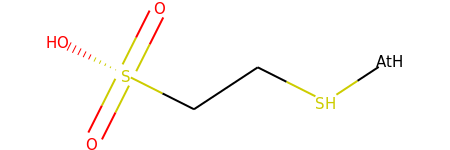

[First Record] adduct_smiles : O=S(=O)(O)CCS[At]
[First Record] common_name : nan
[First Record] covalent_bond_record : 4POL,B,B,CYS,CYS,73,69,?,SG,?,polymer,G,B,COM,COM,.,200,?,S1,?,non-polymer
[First Record] doi : 10.3390/molecules20034928
[First Record] ligand_bond_atom_name : S1
[First Record] ligand_name : COM


'[First Record] ligand_pdb'

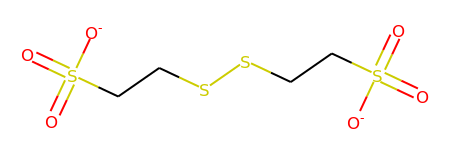

[First Record] ligand_smiles : O=[S](=O)([O-])CCSSCC[S](=O)(=O)[O-]
[First Record] ligand_type : inhibitor
[First Record] long_adduct_name : 4POL_B_CYS_69_?_SG_?_B_COM_200_?_S1_?_cif
[First Record] note : BNP7787
[First Record] reaction_type : Addition-Elimination
[First Record] recovery_strategy : manual
[First Record] short_adduct_name : CYS_SG_COM_S1
[First Record] url : http://doi.org/10.3390/molecules20034928
[First Record] warhead : Disulfide
[First Record] warhead_smiles : SS


In [4]:
print  ( 'size (How many records)',               ':', pdb_4POL.size                         )
print  ( 'DOI',                                   ':', pdb_4POL.doi                          )
print  ( '[First Record] aa_bond_atom_name',      ':', pdb_4POL.ones[0].aa_bond_atom_name    )                       
print  ( '[First Record] aa_name',                ':', pdb_4POL.ones[0].aa_name              )      
print  ( '[First Record] aa_name_atom_name',      ':', pdb_4POL.ones[0].aa_name_atom_name    )                
display( '[First Record] adduct_pdb',                  pdb_4POL.ones[0].adduct_pdb           )         
print  ( '[First Record] adduct_smiles',          ':', pdb_4POL.ones[0].adduct_smiles        )            
print  ( '[First Record] common_name',            ':', pdb_4POL.ones[0].common_name          )          
print  ( '[First Record] covalent_bond_record',   ':', pdb_4POL.ones[0].covalent_bond_record )               
print  ( '[First Record] doi',                    ':', pdb_4POL.ones[0].doi                  )  
print  ( '[First Record] ligand_bond_atom_name',  ':', pdb_4POL.ones[0].ligand_bond_atom_name)                    
print  ( '[First Record] ligand_name',            ':', pdb_4POL.ones[0].ligand_name          )          
display( '[First Record] ligand_pdb',                  pdb_4POL.ones[0].ligand_pdb           )         
print  ( '[First Record] ligand_smiles',          ':', pdb_4POL.ones[0].ligand_smiles        )            
print  ( '[First Record] ligand_type',            ':', pdb_4POL.ones[0].ligand_type          )          
print  ( '[First Record] long_adduct_name',       ':', pdb_4POL.ones[0].long_adduct_name     )               
print  ( '[First Record] note',                   ':', pdb_4POL.ones[0].note                 )   
print  ( '[First Record] reaction_type',          ':', pdb_4POL.ones[0].reaction_type        )            
print  ( '[First Record] recovery_strategy',      ':', pdb_4POL.ones[0].recovery_strategy    )                
print  ( '[First Record] short_adduct_name',      ':', pdb_4POL.ones[0].short_adduct_name    )                
print  ( '[First Record] url',                    ':', pdb_4POL.ones[0].url                  )  
print  ( '[First Record] warhead',                ':', pdb_4POL.ones[0].warhead              )      
print  ( '[First Record] warhead_smiles',         ':', pdb_4POL.ones[0].warhead_smiles       )             

In [5]:
pdb_1PWC = PDB_Cov('1PWC')

[ Automated Recovery ] : 1PWC_A_SER_62_?_OG_?_A_PNM_400_?_C7_A_cif


size (How many records) : 1
DOI : 10.1016/j.jmb.2004.10.076


'[First Record] adduct_pdb'

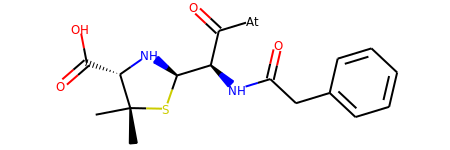

[First Record] covalent_bond_record : 1PWC,A,A,SER,SER,62,62,?,OG,?,polymer,B,A,PNM,PNM,.,400,?,C7,A,non-polymer


'[First Record] ligand_pdb'

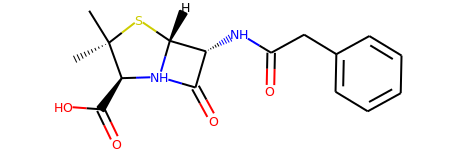

[First Record] ligand_type : None
[First Record] long_adduct_name : 1PWC_A_SER_62_?_OG_?_A_PNM_400_?_C7_A_cif
[First Record] note : None
[First Record] reaction_type : Ring-opening
[First Record] recovery_strategy : automated
[First Record] short_adduct_name : SER_OG_PNM_C7
[First Record] warhead : β-lactam
[First Record] warhead_smiles : [At]C(=O)CCN


In [6]:
print  ( 'size (How many records)',               ':', pdb_1PWC.size                         )
print  ( 'DOI',                                   ':', pdb_1PWC.doi                          )              
display( '[First Record] adduct_pdb',                  pdb_1PWC.ones[0].adduct_pdb           )         
print  ( '[First Record] covalent_bond_record',   ':', pdb_1PWC.ones[0].covalent_bond_record )            
display( '[First Record] ligand_pdb',                  pdb_1PWC.ones[0].ligand_pdb           )             
print  ( '[First Record] ligand_type',            ':', pdb_1PWC.ones[0].ligand_type          )          
print  ( '[First Record] long_adduct_name',       ':', pdb_1PWC.ones[0].long_adduct_name     )               
print  ( '[First Record] note',                   ':', pdb_1PWC.ones[0].note                 )   
print  ( '[First Record] reaction_type',          ':', pdb_1PWC.ones[0].reaction_type        )            
print  ( '[First Record] recovery_strategy',      ':', pdb_1PWC.ones[0].recovery_strategy    )                
print  ( '[First Record] short_adduct_name',      ':', pdb_1PWC.ones[0].short_adduct_name    )   
print  ( '[First Record] warhead',                ':', pdb_1PWC.ones[0].warhead              )      
print  ( '[First Record] warhead_smiles',         ':', pdb_1PWC.ones[0].warhead_smiles       )   